In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Load MNIST dataset

In [13]:
# Define a transform to normalize and binarize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the images
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Definne the VAE

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [15]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [16]:
# Initialize the VAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()/len(data):.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch [1/10], Batch [0/469], Loss: 489.1502
Epoch [1/10], Batch [100/469], Loss: 208.4971
Epoch [1/10], Batch [200/469], Loss: 194.8634
Epoch [1/10], Batch [300/469], Loss: 178.0520
Epoch [1/10], Batch [400/469], Loss: 177.5482
Epoch [1/10], Average Loss: 203.4425
Epoch [2/10], Batch [0/469], Loss: 173.3476
Epoch [2/10], Batch [100/469], Loss: 177.5736
Epoch [2/10], Batch [200/469], Loss: 177.4388
Epoch [2/10], Batch [300/469], Loss: 168.8157
Epoch [2/10], Batch [400/469], Loss: 168.3416
Epoch [2/10], Average Loss: 172.6812
Epoch [3/10], Batch [0/469], Loss: 165.1755
Epoch [3/10], Batch [100/469], Loss: 165.0112
Epoch [3/10], Batch [200/469], Loss: 175.0616
Epoch [3/10], Batch [300/469], Loss: 165.6582
Epoch [3/10], Batch [400/469], Loss: 164.0275
Epoch [3/10], Average Loss: 166.6088
Epoch [4/10], Batch [0/469], Loss: 159.6357
Epoch [4/10], Batch [100/469], Loss: 163.2424
Epoch [4/10], Batch [200/469], Loss: 163.5820
Epoch [4/10], Batch [300/469], Loss: 159.9962
Epoch [4/10], Batch [40

In [47]:
# Generate new images from the latent space
model.eval()
with torch.no_grad():
    n = 15  # Figure with 15x15 digits
    digit_size = 28
    figure = torch.zeros((digit_size * n, digit_size * n))

    # Linearly spaced coordinates on the unit square
    grid_x = torch.linspace(-2, 2, n)
    grid_y = torch.linspace(-2, 2, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]], device=device)
            x_decoded = model.decode(z)
            digit = x_decoded[0].reshape(digit_size, digit_size).cpu()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = (digit>0.5)*1.0

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()

AttributeError: 'RBMmodel' object has no attribute 'eval'

## RBM :

In [19]:
import numpy as np

def read_idx(filename):
    """Read IDX file format and return data as a NumPy array."""
    with open(filename, 'rb') as f:
        # Read the magic number (first 4 bytes)
        magic_number = int.from_bytes(f.read(4), byteorder='big')
        
        # Ensure it's a valid IDX file
        if magic_number != 2051:
            raise ValueError(f"Invalid magic number for IDX image file: {magic_number}")
        
        # Read the number of images (next 4 bytes)
        num_images = int.from_bytes(f.read(4), byteorder='big')
        
        # Read the number of rows (next 4 bytes)
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        
        # Read the number of columns (next 4 bytes)
        num_cols = int.from_bytes(f.read(4), byteorder='big')
        
        # Read the image data
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        
        # Reshape the data into a 3D array (num_images, num_rows, num_cols)
        images = image_data.reshape(num_images, num_rows, num_cols)
        
        return images

# Path to the t10k-images-idx3-ubyte file
file_path = 'data/MNIST/raw/t10k-images-idx3-ubyte'

# Read the images
X = read_idx(file_path)

In [20]:
# Normalize the images to the range [0, 1]
X = X.astype('float32') / 255.0

# Binarize the images using a threshold of 0.5
X = np.where(X > 0.5, 1.0, 0.0)

In [23]:
####   params init   #####

XX = np.array( [item.flatten() for item in X] ).astype('float')
p = XX.shape[1]

n_epochs = 300
batch_size = 16
lr = 0.05


## hyper params : 
q = 2*p  # take q = 1.5x times the input dimension


In [24]:
XX.shape

(10000, 784)

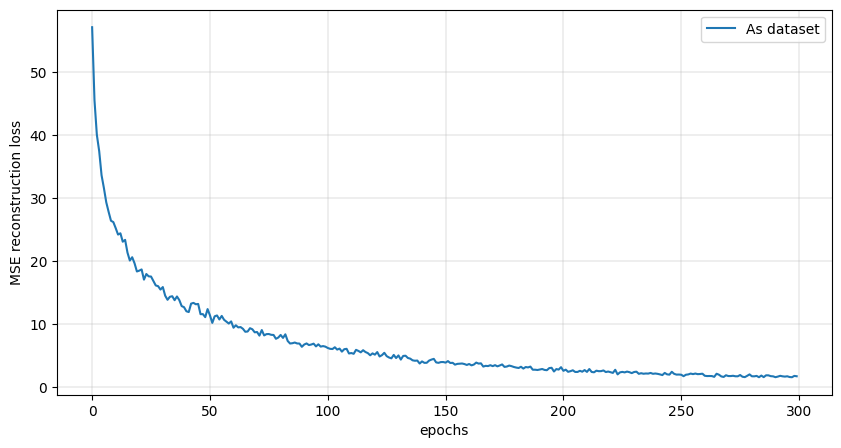

In [26]:
from rbm import *
#####   init the model ########

model = RBMmodel(p, q, XX, n_epochs, batch_size, lr )
loss = model.train()


In [29]:
X[0].shape

(28, 28)

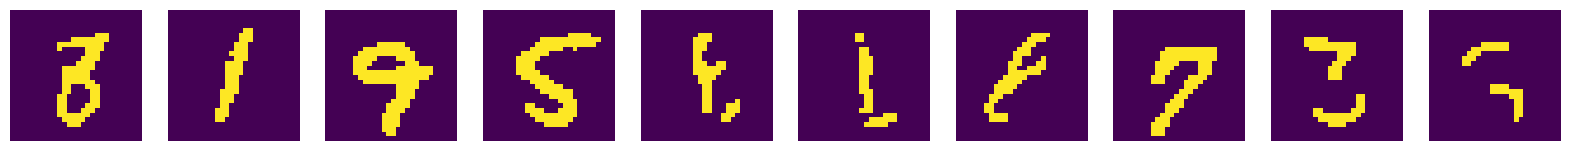

In [52]:
from data_utils import *
img_gen_A = model.generate_images_GibbsSampling(img_size = (28, 28), L= 1000, num_images=10)
visualize_samples(img_gen_A)